In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle0.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle0_c.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle1.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle10.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle100.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle100_c.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle101.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle101_c.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds\Ayrshire cattle\Ayrshirecattle102.jpg
C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

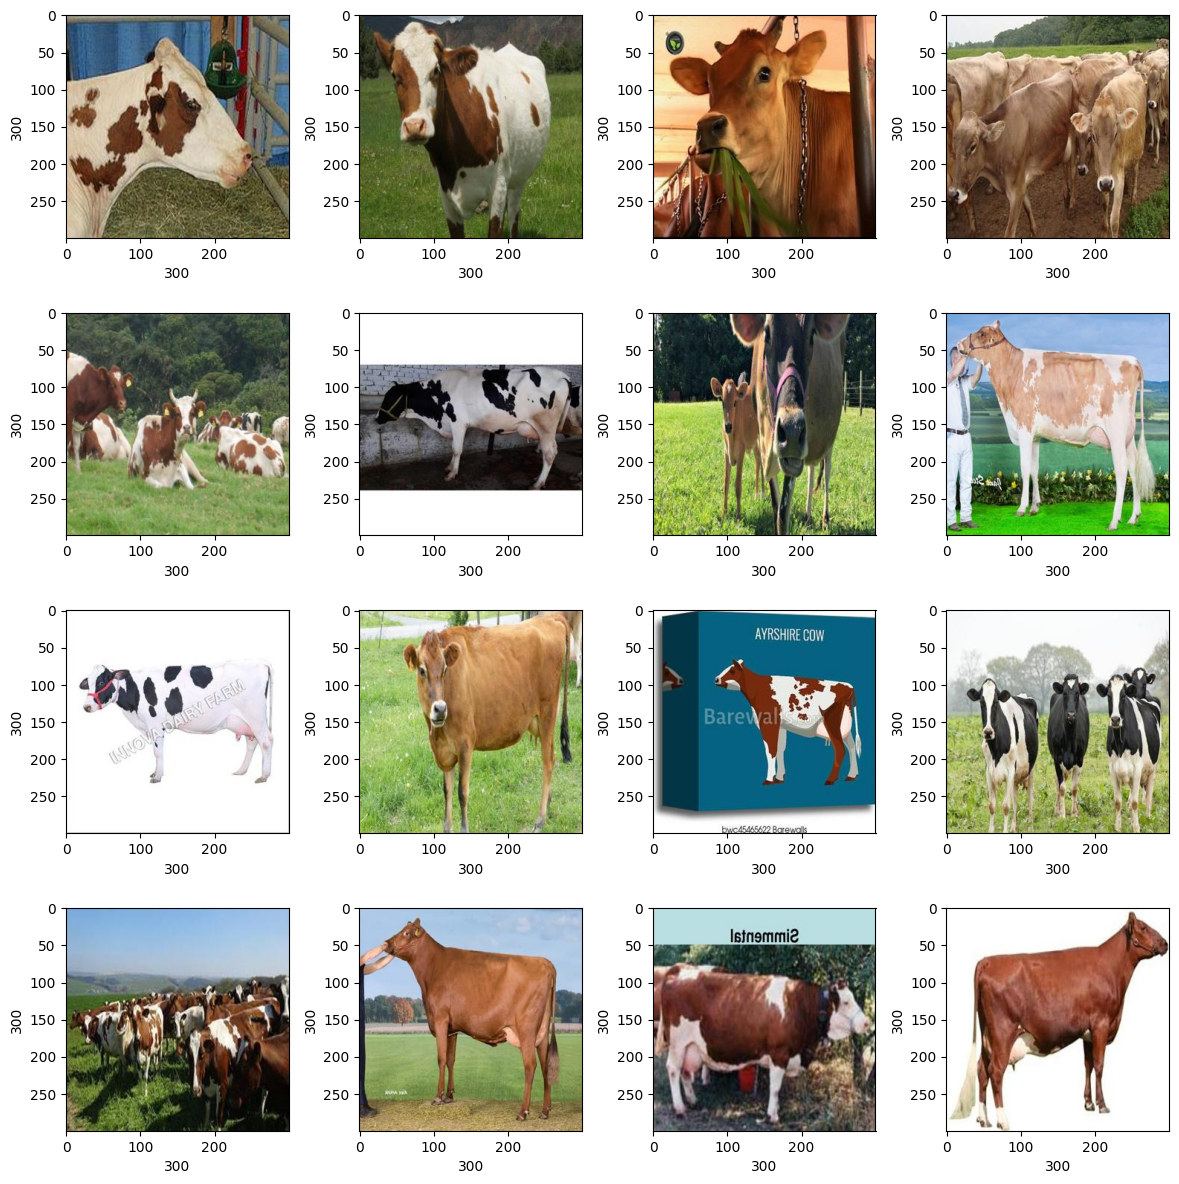

In [5]:
plt.figure(figsize=(12,12))
path=r"C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds"
breeds=os.listdir(path)
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    random_breed = random.choice(breeds)

    # Pick a random image from that breed folder
    random_image = random.choice(os.listdir(path + "/" + random_breed))

    # Full path
    img_path = path + "/" + random_breed + "/" + random_image

    # Read and show
    rand_img = imread(img_path)
    plt.xlabel(rand_img.shape[1],fontsize=10)
    plt.ylabel(rand_img.shape[0],fontsize=10)
    plt.imshow(rand_img)


In [6]:
def convert_img_to_array(image_dir):
    try:
        image=cv2.imread(image_dir)
        if image is not None:
            image=cv2.resize(image,(128,128))
            return img_to_array(image)
        else:
            np.array([])
    except Exception as e:
        print(f"Error,{e}")
        return None

In [7]:
dir=r"C:\Users\shrey\OneDrive\Documents\python\it_project\Cattle Breeds"
image_list,label_list=[],[]
all_labels=['Ayrshire cattle','Brown Swiss cattle','Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle']
binary_labels=[0,1,2,3,4]
temp=-1
for directory in all_labels:
    cattle_image_list=listdir(f"{dir}/{directory}")
    temp+=1
    count=0
    for files in cattle_image_list:
        image_path=f"{dir}/{directory}/{files}"
        image_list.append(convert_img_to_array(image_path))
        label_list.append(binary_labels[temp])
        count=count+1
        if(count==204):
            break


In [8]:
label_counts=pd.DataFrame(label_list).value_counts()
label_counts.head()

0
0    204
1    204
2    204
3    204
4    204
Name: count, dtype: int64

In [9]:
image_list[0].shape

(128, 128, 3)

In [10]:

x_train,x_test,y_train,y_test=train_test_split(image_list,label_list,test_size=0.2,random_state=10)


In [11]:
x_train=np.array(x_train,dtype=np.float16)/255
x_test=np.array(x_test,dtype=np.float16)/255
x_train=x_train.reshape(-1,128,128,3)
x_test=x_test.reshape(-1,128,128,3)

In [12]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    rescale=1./255,
    
)

datagen.fit(x_train)


In [14]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=10)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(652, 128, 128, 3) (652, 5)
(164, 128, 128, 3) (164, 5)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load base model (or start fresh)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the full model on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=output)
model2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Save the full model safely
#model1.save('trained_model.keras')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history=model2.fit(x_train,y_train,epochs=100,validation_data=[x_val,y_val])

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.3021 - loss: 2.0351 - val_accuracy: 0.4634 - val_loss: 1.5379
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.6442 - loss: 1.1934 - val_accuracy: 0.5671 - val_loss: 1.2701
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.7761 - loss: 0.8967 - val_accuracy: 0.5793 - val_loss: 1.2010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.8681 - loss: 0.6963 - val_accuracy: 0.6463 - val_loss: 1.1035
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.8988 - loss: 0.6032 - val_accuracy: 0.6768 - val_loss: 1.0744
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9371 - loss: 0.4887 - val_accuracy: 0.6890 - val_loss: 1.0139
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9586 - loss: 0.4350 - val_accuracy: 0.6951 - val_loss: 0.9926
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.9525 - loss: 0.4074 - val_acc

In [27]:
loss, accuracy = model2.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8529 - loss: 0.9054
Test Loss: 0.9054
Test Accuracy: 0.8529


In [18]:
hist=model2.history

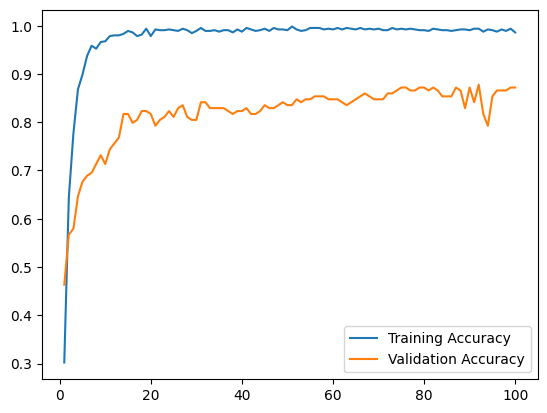

In [19]:
import matplotlib.pyplot as plt
epochs=[i for i in range(1,101)]
plt.plot(epochs,hist.history['accuracy'],label='Training Accuracy')
plt.plot(epochs,hist.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

In [21]:
test_Set=x_val
y_pred=model2.predict(test_Set)
y_pred,y_pred.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step


(array([[9.99985456e-01, 1.42545480e-06, 3.34987135e-06, 3.06242327e-07,
         9.41236249e-06],
        [1.35164640e-07, 2.45358116e-08, 3.89257870e-08, 7.26843200e-06,
         9.99992609e-01],
        [7.50821114e-01, 7.66964004e-05, 2.40444243e-01, 3.92478338e-04,
         8.26552790e-03],
        [7.23250210e-04, 1.17038599e-06, 9.97661829e-01, 5.48017088e-05,
         1.55887625e-03],
        [2.37518574e-08, 1.13758363e-03, 1.33658304e-07, 9.98857975e-01,
         4.29021748e-06],
        [9.99999881e-01, 1.78587420e-08, 1.45837859e-07, 3.40877904e-08,
         2.51818744e-09],
        [9.99991059e-01, 1.86241095e-07, 3.36564494e-06, 4.97213296e-06,
         5.21870447e-07],
        [2.20297650e-03, 3.53765558e-04, 2.71337910e-07, 1.30656688e-03,
         9.96136367e-01],
        [1.14610899e-07, 2.09522577e-09, 4.81704787e-10, 1.44918024e-08,
         9.99999881e-01],
        [1.25525162e-01, 2.57947569e-04, 8.49136055e-01, 2.47085150e-02,
         3.72430193e-04],
        [4

In [22]:
predicted_categories=tf.argmax(y_pred,axis=1)
predicted_categories

<tf.Tensor: shape=(164,), dtype=int64, numpy=
array([0, 4, 0, 2, 3, 0, 0, 4, 4, 2, 3, 0, 4, 0, 0, 3, 0, 2, 3, 4, 1, 2,
       2, 0, 4, 2, 0, 1, 0, 3, 3, 0, 3, 4, 1, 0, 4, 4, 3, 4, 1, 3, 1, 0,
       3, 0, 3, 2, 4, 0, 4, 2, 4, 2, 2, 2, 4, 4, 2, 1, 0, 3, 0, 3, 0, 4,
       4, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 4, 2, 2, 4, 0, 2, 3, 4, 0, 1, 3,
       0, 3, 2, 1, 4, 2, 4, 0, 3, 4, 4, 3, 4, 4, 0, 4, 1, 1, 4, 1, 2, 1,
       3, 3, 3, 4, 1, 3, 2, 3, 0, 3, 0, 0, 0, 0, 4, 3, 3, 0, 2, 3, 3, 4,
       0, 0, 0, 2, 2, 3, 3, 2, 2, 2, 0, 1, 4, 4, 2, 0, 1, 2, 0, 3, 4, 0,
       0, 4, 4, 3, 1, 2, 3, 0, 3, 0])>

In [23]:
if len(y_val.shape) > 1 and y_val.shape[1] > 1:  # one-hot encoded
    true_categories = np.argmax(y_val, axis=1)
else:
    true_categories = y_val  # already in label form

print("True categories:", true_categories)

True categories: [0 4 2 2 1 0 0 4 4 2 3 0 4 0 0 1 0 2 2 4 1 2 2 2 4 2 0 1 0 3 3 4 3 4 3 0 4
 4 3 4 1 3 1 0 3 0 3 2 3 0 4 2 4 3 2 2 4 4 2 1 0 3 0 3 0 4 4 1 2 1 3 1 1 1
 1 1 2 4 2 2 4 0 2 3 3 4 1 4 0 3 2 1 4 2 1 0 3 4 4 3 4 4 1 4 1 1 4 1 0 1 3
 3 1 4 1 3 2 4 0 4 0 0 0 0 4 3 3 4 2 3 3 4 0 0 0 2 2 3 3 2 2 2 0 1 4 4 2 0
 1 2 0 3 2 0 0 3 4 3 1 2 3 0 3 0]


In [24]:
from sklearn.metrics import classification_report
print(classification_report(true_categories,predicted_categories))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.96      0.81      0.88        27
           2       0.93      0.88      0.90        32
           3       0.80      0.85      0.82        33
           4       0.86      0.84      0.85        37

    accuracy                           0.87       164
   macro avg       0.88      0.87      0.87       164
weighted avg       0.88      0.87      0.87       164



In [25]:
#saving the model
model2.save('trained_model.keras')

In [26]:
#Recording history
import json
with open('history.json', 'w') as f:
    json.dump(hist.history, f)

In [ ]:
model = tf.keras.models.load_model('c:\Users\shrey\Downloads\trained_model_2.h5', safe_mode=False)# to check layers


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'trained_model_2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)